## SVM with SMO.

In this notebook I'm planning to build the SVM model using the SMO algorithm. I'll break down the process to the following steps:
* SVM using SMO for the linearly seperable case.
* SVM using SMO for the non seperable case.
* Integrating Kernels into the model. 
* Benchmark the final model against the vanilla SVM in CS231 on the CIFAR dataset.

For each bullet point I'll create some visualization to help us better understand what the model is doing. To begin with the linearly seperable case I will look at the Iris dataset and I'm going to make sure that the data is in fact linearly seperable. 

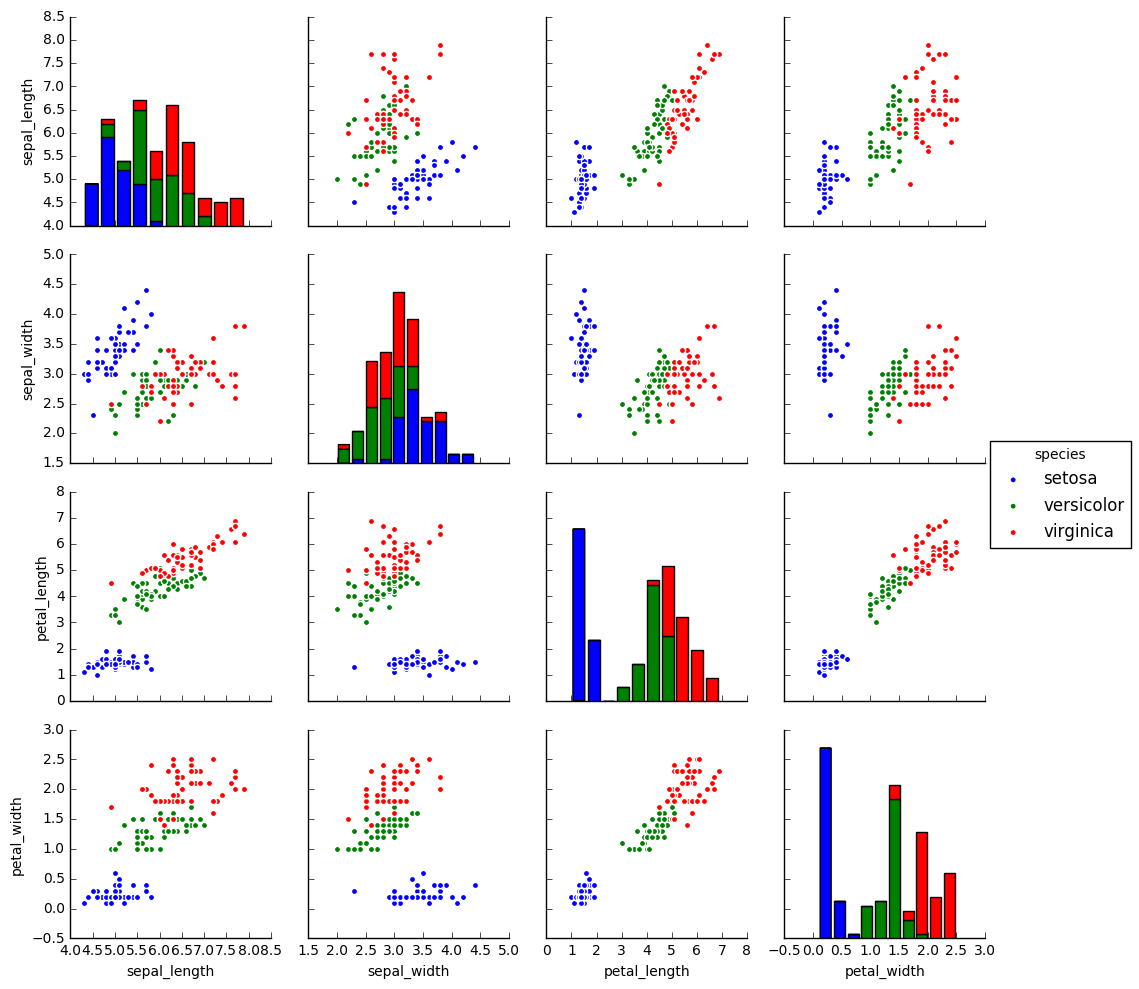

In [1]:
# Let's draw a matrix scatter plot for the Iris dataset 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

iris=sns.load_dataset('iris')
sns.pairplot(iris, hue='species')
plt.show()

%load_ext autoreload
%autoreload 2

Unfortunately it seems that the data is not linearly seperable. However, if we zoom into the plot with ("petal_length", "petal_width") we see that combining "versicolor" and "viginica" can give us what we are looking for.

In [157]:
# I now select "petal_length" and "petal_width" as my variables for the data.
iris_lin_sep = iris[['petal_width','petal_length', 'species']].copy()

# I will combine "versicolor" and "virginica" into one class.
iris_lin_sep.loc[iris_lin_sep['species']=='setosa', 'species'] = -1
iris_lin_sep.loc[iris_lin_sep['species']=='virginica', 'species'] = 1
iris_lin_sep.loc[iris_lin_sep['species']=='versicolor', 'species'] = 1

# From now on we're going to work with numpy arrays instead of dataframes
iris_lin_sep = iris_lin_sep.as_matrix()

Let's take a look at the scatter plot after we combine the labels in to two groups

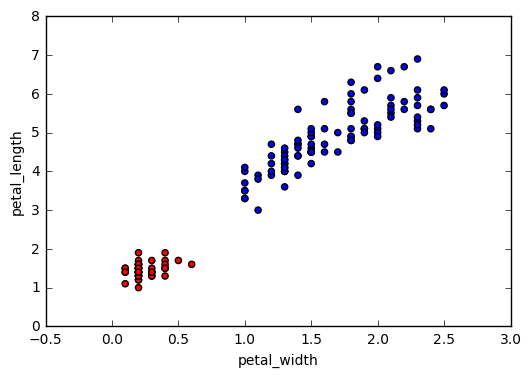

In [428]:
# This function can be used to show scatter plot of our dataset.
def scatter_plot(data, x_label, y_label):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    colors = ['r' if label==-1 else 'b' for label in data[:,2]]
    plt.scatter(data[:,0], data[:,1], c=colors)
    plt.show()
    
# Plot the combined data
scatter_plot_iris(iris_lin_sep, 'petal_width', 'petal_length')

Now that we have a linearly seperable dataset, I'm going to divide the data into train, validation and test datasets. 

In [161]:
from sklearn.cross_validation import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(iris_lin_sep[:,:2], 
                                                            iris_lin_sep[:,2:3], 
                                                            test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_val_test, 
                                                y_val_test,
                                                test_size=0.5)
# Reshape y to be a 1D array
y_train = y_train.reshape(len(y_train))
y_val = y_val.reshape(len(y_val))
y_test = y_test.reshape(len(y_test))

Now we can start training the SVM model.

(w:[0.8235294117744014 1.294117647074059], b:-3.78823529415)


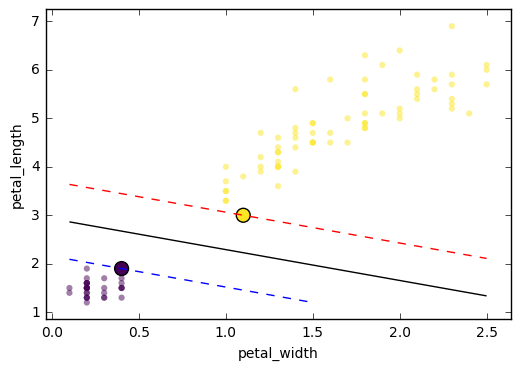

Error rate on the validataion data: 0.0


In [162]:
from models.svm_basic import *

svm = SVM(X_train, y_train, verbose=True)
svm.train()

# Compute the error rate on the validation set.
y_pred = svm.predict(X_val)
y_pred[y_pred >=0] = 1
y_pred[y_pred < 0] = -1
error_rate = sum((y_pred != y_val)) / float(y_val.size)
print "Error rate on the validataion data: {}".format(error_rate)

I would like to also plot the objective function that we are trying to maximize in our SVM model. This is a great sanity check as we expect this to be monotonically increasing. 

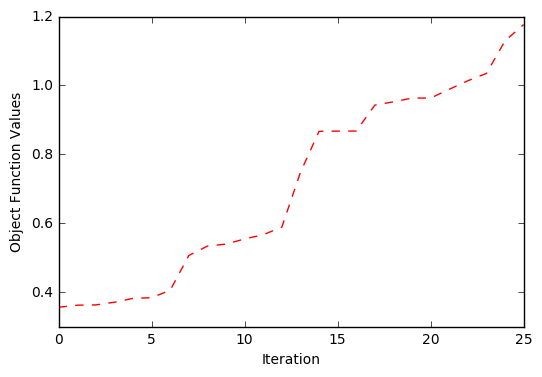

In [163]:
plt.ylabel("Object Function Values")
plt.xlabel("Iteration")
plt.plot(svm.objective_func_values, 'r--')
plt.show()

So far we have been working with a dataset that is linearly seperable. Let's see what happens if we modify our dataset so that it's not linearly seperable. I'm going to artificially change the label of two records in the dataset to make it non-linearly seperable.

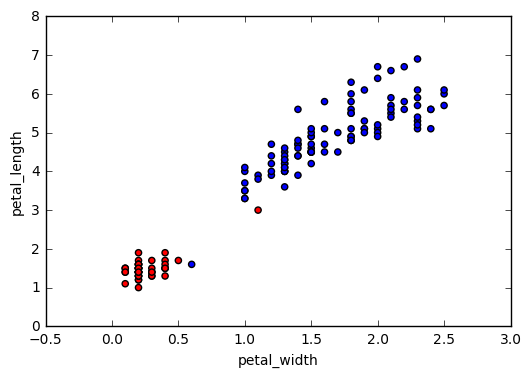

In [429]:
iris_nonlin_sep = iris_lin_sep.copy()
i = iris_nonlin_sep[iris_nonlin_sep[:,2]==-1,0:1].argmax()
j = iris_nonlin_sep[iris_nonlin_sep[:,2]==1,1:2].argmin()
iris_nonlin_sep[:,2:3][i] = 1
iris_nonlin_sep[:, 2:3][j+50] = -1
scatter_plot(iris_nonlin_sep, 'petal_width', 'petal_length')

Now let's try to run our SVM model to on the modified dataset. After runnning the algorithm for a very long time we can see that it does not converge. As a result I added a parameter "check_linearity" to check the linearity assumption before we run the SVM algorithm. If you look at the train function in svm_basic.py you see the default value is True. 

In [405]:
# Lets split the data to X_train and y_train
X_train = iris_nonlin_sep[:,0:2]
y_train = iris_nonlin_sep[:,2]
svm_nonlin = SVM(X_train, y_train, verbose=False)
svm_nonlin.train()


Data is not linearly seperable. Please use the svm_advanced.py


In the example above we saw that a single outlier can make our dataset non linearly seperable and as a result the basic SVM model can not find a plane to seprate our classes. In order to deal with such cases we need to use the SVM model with regularization to allow the model to forgive outliers like above. We are now going to use the SVM with regularization on the dataset above.

(w:[1.5384624373658085 0.7692312186854798], b:-3.07692429045)


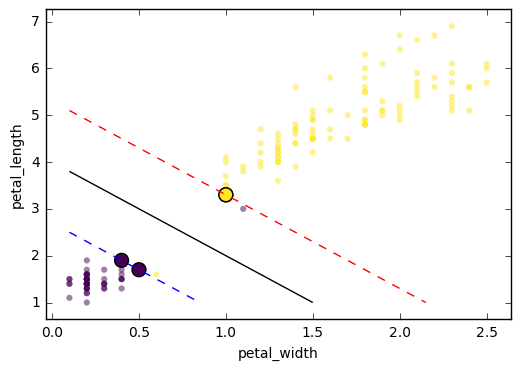

Error rate on the validataion data: 0.0133333333333


In [406]:
from models.svm_advanced import *
svm_adv = SVMAdvanced(X_train, y_train, C=15, verbose=True)
svm_adv.train(print_every=10000)

# Compute the error rate on the validation set.
y_pred = svm_adv.predict(X_train)
y_pred[y_pred >=0] = 1
y_pred[y_pred < 0] = -1
error_rate = sum((y_pred != y_train)) / float(y_train.size)
print "Error rate on the validataion data: {}".format(error_rate)

As a sanity check let's plot the objective function. The objective function should increase monotonically.

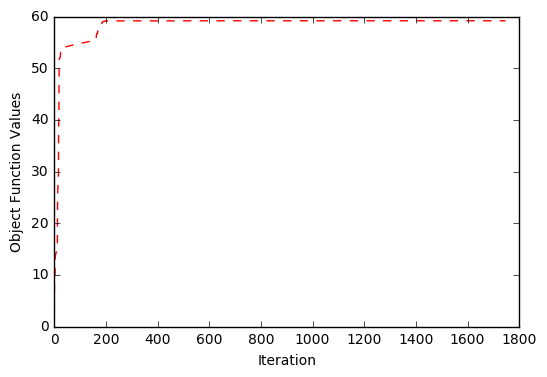

In [407]:
plt.ylabel("Object Function Values")
plt.xlabel("Iteration")
plt.plot(svm_adv.objective_func_values, 'r--')
plt.show()

So far we have focused on linear models where in the first case we assumed the classes are linearly seperable. In the second ase we made the model more flexible to allow for outliers in the data. However, the dundemental assumption was still that a linear model is sufficient for seperating the classes.

Now we are going to work with a dataset where no linear model can do a decent job in seperatin the classes. Let's create this dataset artificially. 

In [434]:
# Let's first create the class with label 1
class_one_r = 1
x1 = np.array([class_one_r*np.sin(np.pi/2 * theta) for theta in np.linspace(0,4,30)])
x2 = np.array([class_one_r*np.cos(np.pi/2 * theta) for theta in np.linspace(0,4,30)])
class_one_y = np.array([1 for i in np.linspace(0, 4, 30)])
class_one_data = np.column_stack((x1,x2,class_one_y))

# Now we create the calss with label 2
class_two_r = 2
z1 = np.array([class_two_r*np.sin(np.pi/2 * theta) for theta in np.linspace(0,4,30)])
z2 = np.array([class_two_r*np.cos(np.pi/2 * theta) for theta in np.linspace(0,4,30)])
class_two_y = np.array([-1 for i in np.linspace(0, 4, 30)])
class_two_data = np.column_stack((z1,z2,class_two_y))

# Our data will be the combination of the two classes
circular_data = np.concatenate((class_one_data, class_two_data))

Let's plot the data to confirm that we can not seperate the classes using a linear model. 

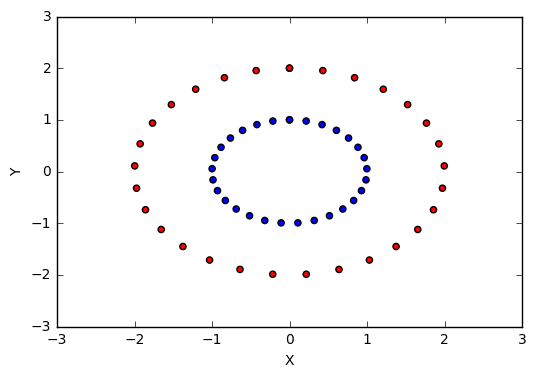

In [435]:
scatter_plot(circular_data, 'X', 'Y')